# thal2 1:1 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d)

from lib.rhs import _redu_c,_full, _redu_full
from lib.rhs import _redu_3dc_thal as _redu_3dc
from lib.rhs import _redu_4dc_thal as _redu_4dc

from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':3.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
etup11 = (.001,.3,100)
eps_list11r = np.linspace(*etup11)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

## Initialize Response Functions

In [9]:
system1 = rsp(idx=0,model_name='thal0_35',**kws1)
system2 = rsp(idx=1,model_name='thal1_35',**kws1)

mkdir ./data/thal0_35/
* Loading LC data...
self.T 6.283185307179586 omfix 1.6947246128737048
* Loading monodromy...
* Floquet Exponent kappa =-0.0359448278078596
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_35/
* Loading LC data...
self.T 6.283185307179586 omfix 1.6947246128737048
* Loading monodromy...
* Floquet Exponent kappa =-0.0359448278078596
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [10]:
recompute_list = ['h_data_thal0_35','h_data_thal1_35','p_data_thal0_35','p_data_thal1_35']
# recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
         'NH':2048,'save_fig':False,
         'recompute_list':recompute_list}

# del=0.0

In [11]:
del11_p0 = 0
a11_p0 = nm.nmCoupling(**kw_nm, del1=del11_p0)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
h del vals 0 0
* Computing H thal1_35, order=0...
h del vals 0 0
* Computing H thal0_35, order=1...
h del vals 0 0
* Computing H thal1_35, order=1...
h del vals 0 0
* Computing H thal0_35, order=2...
h del vals 0 0
* Computing H thal1_35, order=2...
h del vals 0 0
* Computing H thal0_35, order=3...
h del vals 0 0
* Computing H thal1_35, order=3...
h del vals 0 0


## H functions

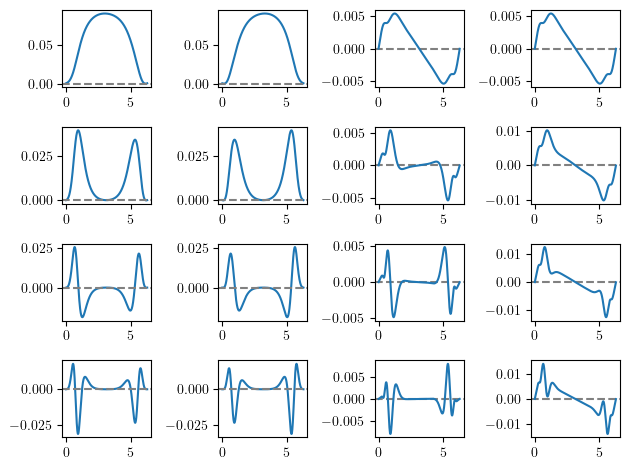

In [12]:
aa = a11_p0
fig,axs = plt.subplots(aa.system1.miter,4)
etemp = .1
h = 0
for k in range(aa.system1.miter):
    axs[k,0].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    axs[k,1].plot(aa.x,etemp**(k+1)*aa.system2.h['lam'][k](aa.x))
    
    axs[k,0].axhline(0,color='gray',ls='--')
    axs[k,1].axhline(0,color='gray',ls='--')
    axs[k,2].axhline(0,color='gray',ls='--')
    axs[k,3].axhline(0,color='gray',ls='--')

    d = aa.system1.h['lam'][k](aa.x)-aa.system2.h['lam'][k](aa.x)
    axs[k,2].plot(aa.x,etemp**(k+1)*d)
    h += etemp**(k+1)*d
    axs[k,3].plot(aa.x,h)

plt.tight_layout()

### p_i

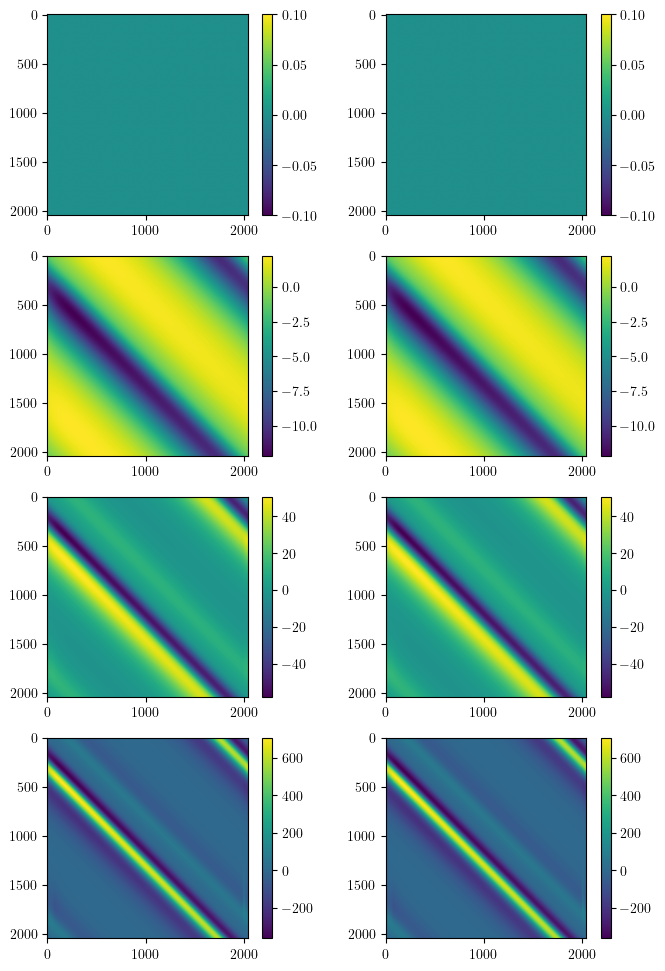

In [13]:
fig,axs = plt.subplots(a11_p0.system1.miter,2,
                       figsize=(8,a11_p0.system1.miter*3))
for i in range(a11_p0.system1.miter):
    im = axs[i,0].imshow(a11_p0.system1.p['dat'][i])
    plt.colorbar(im,ax=axs[i,0])
    im = axs[i,1].imshow(a11_p0.system2.p['dat'][i].T)
    plt.colorbar(im,ax=axs[i,1])

In [14]:
# del11_p0 = 0
# a11o5_p0 = nm.nmCoupling(system1o5,system2o5,
#                          recompute_list=['k_thal0','k_thal1'],
#                          _n=('om0',1),_m=('om1',1),
#                          save_fig=False,del1=del11_p0,
#                          iso_mode=True)

Check expansion for gz and gi to compare to expansion in Nicks et al 2024.

In [15]:
# coupling_object = a11_p0
# fig,axs = plt.subplots(coupling_object.system1.miter,1)

# x = coupling_object.x

# for k in range(coupling_object.system1.miter):
#     diff = coupling_object.system1.h['lam'][k](-x) - coupling_object.system1.h['lam'][k](x)
#     axs[k].plot(x,diff,label='Order {}'.format(k))
#     axs[k].legend()
#     axs[k].set_xlabel(r'$\phi$') # the string must have 'r' in front
#     axs[k].set_ylabel(r'$\mathcal{H}_1^{('+str(k)+r')}(-\phi)-\mathcal{H}_1^{('+str(k)+r')}(\phi)$')
# axs[0].set_title(r'(-2*) Odd Parts')
# plt.tight_layout()

In [16]:
# coupling_object = a11_p0
# fig,axs = plt.subplots(coupling_object.system1.miter,1)

# x = coupling_object.x

# for k in range(coupling_object.system1.miter):
#     diff = coupling_object.system1.h['lam'][k](-x) - coupling_object.system1.h['lam'][k](x)
#     axs[k].plot(x,diff,label='Order {}'.format(k))
#     axs[k].legend()
#     axs[k].set_xlabel(r'$\phi$') # the string must have 'r' in front
#     axs[k].set_ylabel(r'$\mathcal{H}_1^{('+str(k)+r')}(-\phi)-\mathcal{H}_1^{('+str(k)+r')}(\phi)$')
# axs[0].set_title(r'(-2*) Odd Parts')
# plt.tight_layout()

## Get Branches Full

In [17]:
kw_p0 = {'a':a11_p0,'del1':del11_p0,'recompute':False,
         'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [18]:
data_p0_list = []

In [19]:
in_dicts = [dict(init=3,eps_init=0.01,eps_final=0.0005,deps=-.001),
            dict(init=3,eps_init=0.01,eps_final=0.3,deps=.01),
            dict(init=.1,eps_init=0.2,eps_final=0.1,deps=-.01),
            dict(init=.1,eps_init=0.2,eps_final=0.3,deps=.01),
            dict(init=5,eps_init=0.2,eps_final=0.1,deps=-.01),
            dict(init=5,eps_init=0.2,eps_final=0.3,deps=.01),
            dict(init=.1,eps_init=0.11,eps_final=0.1,deps=-.001),
            dict(init=5,eps_init=0.11,eps_final=0.1,deps=-.001),]

In [20]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)
fname = kw_p0['bifdir']+'hyper_thal2_11_p0.txt'

fname1 td_branch_init=3_nm=11_del=0_ei=0.01_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=3_nm=11_del=0_ei=0.01_ef=0.0005_de=-0.001.txt
fname1 td_branch_init=3_nm=11_del=0_ei=0.01_ef=0.3_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0_ei=0.01_ef=0.3_de=0.01.txt
fname1 td_branch_init=0.1_nm=11_del=0_ei=0.2_ef=0.1_de=-0.01.txt
fname2 ts_branch_init=0.1_nm=11_del=0_ei=0.2_ef=0.1_de=-0.01.txt
fname1 td_branch_init=0.1_nm=11_del=0_ei=0.2_ef=0.3_de=0.01.txt
fname2 ts_branch_init=0.1_nm=11_del=0_ei=0.2_ef=0.3_de=0.01.txt
fname1 td_branch_init=5_nm=11_del=0_ei=0.2_ef=0.1_de=-0.01.txt
fname2 ts_branch_init=5_nm=11_del=0_ei=0.2_ef=0.1_de=-0.01.txt
fname1 td_branch_init=5_nm=11_del=0_ei=0.2_ef=0.3_de=0.01.txt
fname2 ts_branch_init=5_nm=11_del=0_ei=0.2_ef=0.3_de=0.01.txt
fname1 td_branch_init=0.1_nm=11_del=0_ei=0.11_ef=0.1_de=-0.001.txt
fname2 ts_branch_init=0.1_nm=11_del=0_ei=0.11_ef=0.1_de=-0.001.txt
fname1 td_branch_init=5_nm=11_del=0_ei=0.11_ef=0.1_de=-0.001.txt
fname2 ts_branch_init=5_nm=11_d

In [21]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [22]:
data_list_r3d = []

In [23]:
kw_follow_r3d = {'a':a11_p0,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [24]:
in_dicts_r3d = [dict(init=3,eps_tup=(.05,.31,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001))]

In [25]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_11_p0.txt'

eps_tup (0.05, 0.31, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [26]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

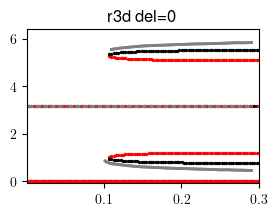

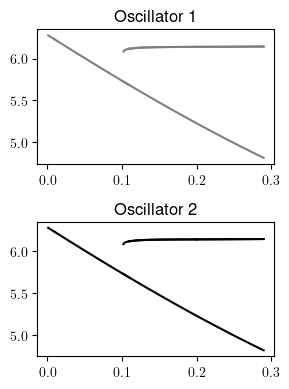

In [27]:
quick_plot_combined(a11_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

# del=0.0005

In [28]:
del11_p0005 = .0005
a11_p0005 = nm.nmCoupling(**kw_nm, del1=del11_p0005)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
h del vals 0.01 0
* Computing H thal1_35, order=0...
h del vals 0.01 0
* Computing H thal0_35, order=1...
h del vals 0.01 0
* Computing H thal1_35, order=1...
h del vals 0.01 0
* Computing H thal0_35, order=2...
h del vals 0.01 0
* Computing H thal1_35, order=2...
h del vals 0.01 0
* Computing H thal0_35, order=3...
h del vals 0.01 0
* Computing H thal1_35, order=3...
h del vals 0.01 0


## H functions

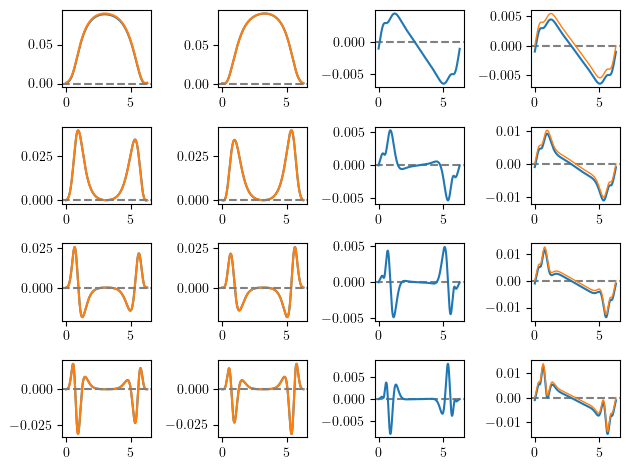

In [29]:
aa = a11_p0005
fig,axs = plt.subplots(aa.system1.miter,4)
etemp = .1
h = 0; h2 = 0
for k in range(aa.system1.miter):
    axs[k,0].plot(aa.x,etemp**(k+1)*aa.system1.h['lam'][k](aa.x))
    axs[k,0].plot(aa.x,etemp**(k+1)*a11_p0.system1.h['lam'][k](aa.x))
    
    axs[k,1].plot(aa.x,etemp**(k+1)*aa.system2.h['lam'][k](aa.x))
    axs[k,1].plot(aa.x,etemp**(k+1)*a11_p0.system2.h['lam'][k](aa.x))
    
    axs[k,0].axhline(0,color='gray',ls='--')
    axs[k,1].axhline(0,color='gray',ls='--')
    axs[k,2].axhline(0,color='gray',ls='--')
    axs[k,3].axhline(0,color='gray',ls='--')

    d = aa.system1.h['lam'][k](aa.x)-aa.system2.h['lam'][k](aa.x)
    axs[k,2].plot(aa.x,etemp**(k+1)*d)
    h += etemp**(k+1)*d
    axs[k,3].plot(aa.x,h)

    d2 = a11_p0.system1.h['lam'][k](aa.x)-a11_p0.system2.h['lam'][k](aa.x)
    h2 += etemp**(k+1)*d2
    axs[k,3].plot(aa.x,h2,lw=1)

plt.tight_layout()

### p_i

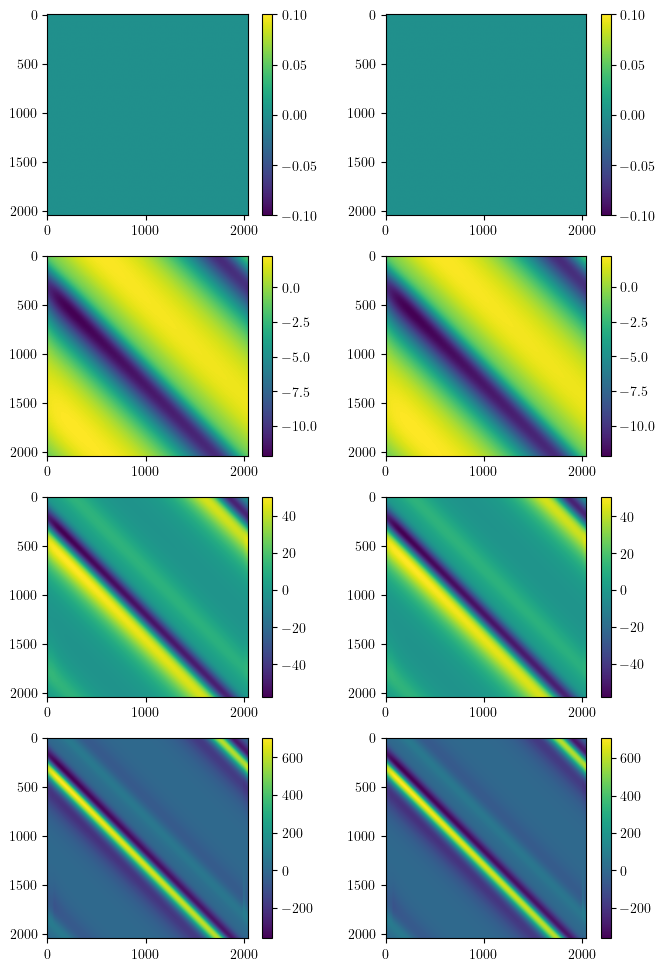

In [30]:
fig,axs = plt.subplots(a11_p0005.system1.miter,2,
                       figsize=(8,a11_p0005.system1.miter*3))
for i in range(a11_p0005.system1.miter):
    im = axs[i,0].imshow(a11_p0005.system1.p['dat'][i])
    plt.colorbar(im,ax=axs[i,0])
    im = axs[i,1].imshow(a11_p0005.system2.p['dat'][i].T)
    plt.colorbar(im,ax=axs[i,1])

## Get Branches Full

In [31]:
kw_p0005 = {'a':a11_p0005,'del1':del11_p0005,'recompute':False,
            'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [32]:
data_p0005_list = []

In [33]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.0005),
               dict(init=3,eps_init=0.02,eps_final=0.3,deps=.01),
               dict(init=.5,eps_init=0.2,eps_final=0.27,deps=.01),
               dict(init=.5,eps_init=0.2,eps_final=0.08,deps=-.005),
               dict(init=6,eps_init=0.2,eps_final=0.3,deps=.01),
               dict(init=6,eps_init=0.2,eps_final=0.125,deps=-.005)]

In [34]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0005)
    data_p0005_list.append(dat)
fname = kw_p0005['bifdir']+'hyper_thal2_11_p0005.txt'

fname1 td_branch_init=3_nm=11_del=0.0005_ei=0.02_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=3_nm=11_del=0.0005_ei=0.02_ef=0.0005_de=-0.0005.txt
fname1 td_branch_init=3_nm=11_del=0.0005_ei=0.02_ef=0.3_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.0005_ei=0.02_ef=0.3_de=0.01.txt
fname1 td_branch_init=0.5_nm=11_del=0.0005_ei=0.2_ef=0.27_de=0.01.txt
fname2 ts_branch_init=0.5_nm=11_del=0.0005_ei=0.2_ef=0.27_de=0.01.txt
fname1 td_branch_init=0.5_nm=11_del=0.0005_ei=0.2_ef=0.08_de=-0.005.txt
fname2 ts_branch_init=0.5_nm=11_del=0.0005_ei=0.2_ef=0.08_de=-0.005.txt
fname1 td_branch_init=6_nm=11_del=0.0005_ei=0.2_ef=0.3_de=0.01.txt
fname2 ts_branch_init=6_nm=11_del=0.0005_ei=0.2_ef=0.3_de=0.01.txt
fname1 td_branch_init=6_nm=11_del=0.0005_ei=0.2_ef=0.125_de=-0.005.txt
fname2 ts_branch_init=6_nm=11_del=0.0005_ei=0.2_ef=0.125_de=-0.005.txt


In [35]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [36]:
data_list_r3d = []

In [37]:
kw_follow_r3d = {'a':a11_p0005,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [38]:
in_dicts_r3d = [dict(init=3,eps_tup=(.05,.31,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001))]

In [39]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_11_p0005.txt'

eps_tup (0.05, 0.31, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [40]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

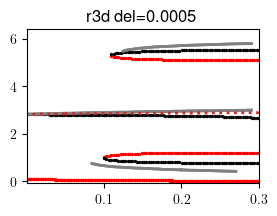

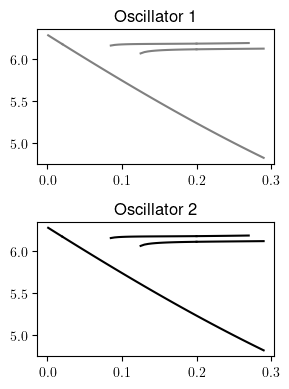

In [41]:
quick_plot_combined(a11_p0005,
                    kw_f={'data_list':data_p0005_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

## Sims

In [ ]:
eps11_p0005 = 0.09
th_init11_p0005 = 0

In [ ]:
dt = .01;T_p008=2000
t11_p0005 = np.arange(0,T_p008,dt)
args11_p0005 = {'args':(a11_p0005,eps11_p0005,del11_p0005),
               't_eval':t11_p0005,**kw_sim}

In [ ]:
y0a = a11_p0005.system1.lc['dat'][int((th_init11_p0005/(2*np.pi)) * a11_p0005.system1.TN),:]
y0b = a11_p0005.system2.lc['dat'][int((0/(2*np.pi)) * a11_p0005.system2.TN),:]

y0_p008 = np.array([y0a,y0b]).flatten()

solf11_p0005 = solve_ivp(_full,[0,t11_p0005[-1]],
                        y0_p008, **args11_p0005)

In [ ]:
solr11_p0005 = solve_ivp(_redu_c,[0,t11_p0005[-1]],
                        [th_init11_p0005],**args11_p0005)

In [ ]:
# solr12b_p008 = solve_ivp(_redu_3dc,[0,t11_p0005[-1]],
#                     [th_init11_p0005,0,0],**args11_p0005)

In [ ]:
tp12a_p008, phasea11_p0005 = get_phase(t11_p0005,solf11_p0005.y.T[:,:4],
                            skipn=50,system1=a11_p0005.system1)
tp12b_p008, phaseb11_p0005 = get_phase(t11_p0005,solf11_p0005.y.T[:,4:],
                            skipn=50,system1=a11_p0005.system2)

### Plot

In [ ]:
fig,axs = plt.subplots()
y = np.mod(phasea11_p0005 - a11_p0005.om*phaseb11_p0005,2*np.pi)
axs.scatter(tp12a_p008,y,s=1,alpha=.5,color='black')

axs.plot(t11_p0005,np.mod(solr11_p0005.y.T,2*np.pi),color='tab:red')

# axs.plot(t11_p0005*a11_p0005.om,np.mod(solr12b_p008.y[0]-a11_p0005.om*solr12b_p008.y[2],2*np.pi),color='tab:blue')

#axs.plot(t12*a12.om,np.mod(solr12c.y[0]-a12.om*solr12c.y[2],2*np.pi),color='tab:green')
#axs.scatter(sol_full.t[::skipn],np.mod(phase2,1),s=1)

axs.set_ylim(-.5,2*np.pi+.5)

In [ ]:
fig,axs = plt.subplots(figsize=(6,2))
axs.plot(solf11_p0005.t,solf11_p0005.y.T[:,0])
axs.plot(solf11_p0005.t,solf11_p0005.y.T[:,4])
axs.set_xlim(250,350)

# del=0.001

In [46]:
del11_p001 = .001
a11_p001 = nm.nmCoupling(**kw_nm, del1=del11_p001)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


* Computing H thal0_35, order=2...


* Computing H thal1_35, order=2...


* Computing H thal0_35, order=3...


* Computing H thal1_35, order=3...


## Get Branches Full

In [47]:
kw_p001 = {'a':a11_p001,'del1':del11_p001,'recompute':False,
            'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [48]:
data_p001_list = []

In [49]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.0005),
               dict(init=3,eps_init=0.02,eps_final=0.3,deps=.01),
               dict(init=.5,eps_init=0.2,eps_final=0.27,deps=.01),
               dict(init=.5,eps_init=0.2,eps_final=0.04,deps=-.01),
               dict(init=6,eps_init=0.2,eps_final=0.3,deps=.01),
               dict(init=6,eps_init=0.2,eps_final=0.14,deps=-.01)]

In [50]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p001)
    data_p001_list.append(dat)
fname = kw_p001['bifdir']+'hyper_thal2_11_p001.txt'

fname1 td_branch_init=3_nm=11_del=0.001_ei=0.02_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=3_nm=11_del=0.001_ei=0.02_ef=0.0005_de=-0.0005.txt
fname1 td_branch_init=3_nm=11_del=0.001_ei=0.02_ef=0.3_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.001_ei=0.02_ef=0.3_de=0.01.txt
fname1 td_branch_init=0.5_nm=11_del=0.001_ei=0.2_ef=0.27_de=0.01.txt
fname2 ts_branch_init=0.5_nm=11_del=0.001_ei=0.2_ef=0.27_de=0.01.txt
fname1 td_branch_init=0.5_nm=11_del=0.001_ei=0.2_ef=0.04_de=-0.01.txt
fname2 ts_branch_init=0.5_nm=11_del=0.001_ei=0.2_ef=0.04_de=-0.01.txt
fname1 td_branch_init=6_nm=11_del=0.001_ei=0.2_ef=0.3_de=0.01.txt
fname2 ts_branch_init=6_nm=11_del=0.001_ei=0.2_ef=0.3_de=0.01.txt
fname1 td_branch_init=6_nm=11_del=0.001_ei=0.2_ef=0.14_de=-0.01.txt
fname2 ts_branch_init=6_nm=11_del=0.001_ei=0.2_ef=0.14_de=-0.01.txt


In [51]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [52]:
data_list_r3d = []

In [53]:
kw_follow_r3d = {'a':a11_p001,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [54]:
in_dicts_r3d = [dict(init=3,eps_tup=(.05,.31,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001))]

In [55]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_11_p001.txt'

eps_tup (0.05, 0.31, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [56]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

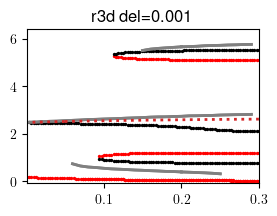

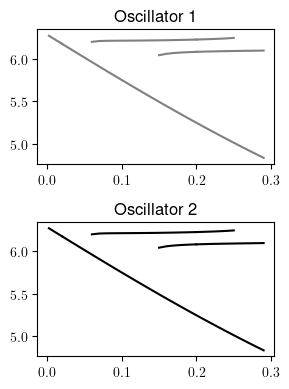

In [57]:
quick_plot_combined(a11_p001,
                    kw_f={'data_list':data_p001_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

# del=0.0015

In [71]:
del11_p0015 = .0015
a11_p0015 = nm.nmCoupling(**kw_nm, del1=del11_p0015)

pfactor 20
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


* Computing H thal0_35, order=3...


* Computing H thal1_35, order=3...


## Get Branches Full

In [72]:
kw_p0015 = {'a':a11_p0015,'del1':del11_p0015,'recompute':False,
            'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [73]:
data_p0015_list = []

In [74]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.0005),
            dict(init=3,eps_init=0.02,eps_final=0.3,deps=.01),
            dict(init=.5,eps_init=0.05,eps_final=0.061,deps=.001),
            dict(init=.5,eps_init=0.05,eps_final=0.035,deps=-.002),
            dict(init=6,eps_init=0.2,eps_final=0.3,deps=.01),
            dict(init=6,eps_init=0.2,eps_final=0.16,deps=-.01)]

In [75]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p0015)
    data_p0015_list.append(dat)
fname = kw_p0015['bifdir']+'hyper_thal2_11_p0015.txt'

fname1 td_branch_init=3_nm=11_del=0.0015_ei=0.02_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=3_nm=11_del=0.0015_ei=0.02_ef=0.0005_de=-0.0005.txt
fname1 td_branch_init=3_nm=11_del=0.0015_ei=0.02_ef=0.3_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.0015_ei=0.02_ef=0.3_de=0.01.txt
fname1 td_branch_init=0.5_nm=11_del=0.0015_ei=0.05_ef=0.061_de=0.001.txt
fname2 ts_branch_init=0.5_nm=11_del=0.0015_ei=0.05_ef=0.061_de=0.001.txt
fname1 td_branch_init=0.5_nm=11_del=0.0015_ei=0.05_ef=0.035_de=-0.002.txt
fname2 ts_branch_init=0.5_nm=11_del=0.0015_ei=0.05_ef=0.035_de=-0.002.txt
fname1 td_branch_init=6_nm=11_del=0.0015_ei=0.2_ef=0.3_de=0.01.txt
fname2 ts_branch_init=6_nm=11_del=0.0015_ei=0.2_ef=0.3_de=0.01.txt
fname1 td_branch_init=6_nm=11_del=0.0015_ei=0.2_ef=0.16_de=-0.01.txt
fname2 ts_branch_init=6_nm=11_del=0.0015_ei=0.2_ef=0.16_de=-0.01.txt


In [76]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [77]:
data_list_r3d = []

In [78]:
kw_follow_r3d = {'a':a11_p0015,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_thal2/'}

In [79]:
in_dicts_r3d = [dict(init=3,eps_tup=(.05,.31,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001))]

In [80]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_thal2_11_p0015.txt'

eps_tup (0.05, 0.31, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [81]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot

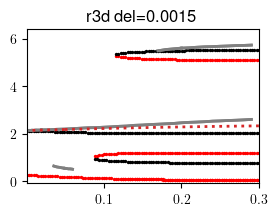

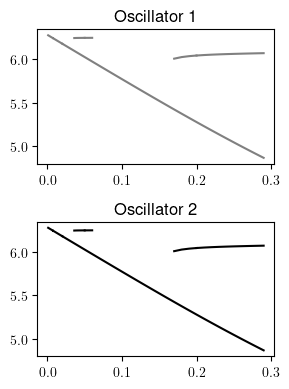

In [83]:
quick_plot_combined(a11_p0015,
                    kw_f={'data_list':data_p0015_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup11})

# del=0.002

In [86]:
del11_p002 = .002
a11_p002 = nm.nmCoupling(**kw_nm, del1=del11_p002)

pfactor 20
* Loading H thal0_35, order=0...
* Loading H thal1_35, order=0...
* Loading H thal0_35, order=1...
* Loading H thal1_35, order=1...
* Loading H thal0_35, order=2...
* Loading H thal1_35, order=2...
* Loading H thal0_35, order=3...
* Loading H thal1_35, order=3...


* Computing H thal1_35, order=2...


* Computing H thal0_35, order=3...


* Computing H thal1_35, order=3...


## Get Branches Full

In [71]:
kw_p002 = {'a':a11_p002,'del1':del11_p002,'recompute':False,
            'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [72]:
data_p002_list = []

In [73]:
in_dicts = [dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.0005),
               dict(init=3,eps_init=0.02,eps_final=0.0589,deps=.0005),
               dict(init=.1,eps_init=0.2,eps_final=0.3,deps=.01),
               dict(init=.1,eps_init=0.2,eps_final=0.18,deps=-.005)]

In [74]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_p002)
    data_p002_list.append(dat)
fname = kw_p002['bifdir']+'hyper_thal2_11_p002.txt'

fname1 td_branch_init=3_nm=11_del=0.002_ei=0.02_ef=0.0005_de=-0.0005.txt
fname2 ts_branch_init=3_nm=11_del=0.002_ei=0.02_ef=0.0005_de=-0.0005.txt
fname1 td_branch_init=3_nm=11_del=0.002_ei=0.02_ef=0.0589_de=0.0005.txt
fname2 ts_branch_init=3_nm=11_del=0.002_ei=0.02_ef=0.0589_de=0.0005.txt
fname1 td_branch_init=0.1_nm=11_del=0.002_ei=0.2_ef=0.3_de=0.01.txt
fname2 ts_branch_init=0.1_nm=11_del=0.002_ei=0.2_ef=0.3_de=0.01.txt
fname1 td_branch_init=0.1_nm=11_del=0.002_ei=0.2_ef=0.18_de=-0.005.txt
fname2 ts_branch_init=0.1_nm=11_del=0.002_ei=0.2_ef=0.18_de=-0.005.txt


In [75]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Plot

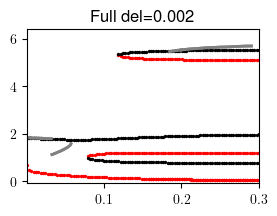

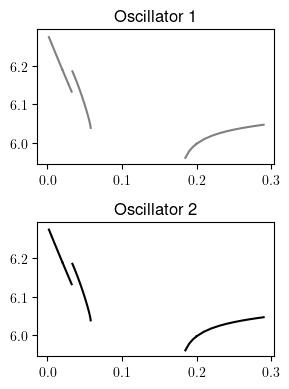

In [76]:
quick_plot_combined(a11_p002,
                    kw_f={'data_list':data_p002_list},
                    #kw_r3d={'data_list':data_r3d_p002_list},
                    kw_r={'etup':etup11})

# del=0.0025

In [77]:
del11_p0025 = .0025
a11_p0025 = nm.nmCoupling(**kw_nm, del1=del11_p0025)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Computing H thal0_35, order=0...
* Computing H thal1_35, order=0...
* Computing H thal0_35, order=1...
* Computing H thal1_35, order=1...
* Computing H thal0_35, order=2...
* Computing H thal1_35, order=2...
* Computing H thal0_35, order=3...
* Computing H thal1_35, order=3...


* Computing H thal0_35, order=2...


* Computing H thal1_35, order=2...


* Computing H thal0_35, order=3...


* Computing H thal1_35, order=3...


## Get Branches Full

In [78]:
# kw_p0025 = {'a':a11_p0025,'del1':del11_p0025,'recompute':False,
#             'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [79]:
# data_p0025_list = []

In [80]:
# # mid 1
# dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.0005,deps=-.005,**kw_p0025)
# data_p0025_list.append(dat)

In [81]:
# # mid 2
# dat = follow_phase_diffs(init=2,eps_init=0.02,eps_final=0.06,deps=.005,**kw_p0025)
# data_p0025_list.append(dat)

In [82]:
# # top 1f
# dat = follow_phase_diffs(init=6,eps_init=0.25,eps_final=0.3,deps=.01,**kw_p0025)
# data_p0025_list.append(dat)

In [83]:
# # top 1b
# dat = follow_phase_diffs(init=6,eps_init=0.25,eps_final=0.2,deps=-.005,**kw_p0025)
# data_p0025_list.append(dat)

In [84]:
# # bot 1f
# dat = follow_phase_diffs(init=1,eps_init=0.2,eps_final=0.3,deps=.01,**kw_p0025)
# data_p0025_list.append(dat)

In [85]:
# # bot 1b
# dat = follow_phase_diffs(init=.5,eps_init=0.2,eps_final=0.18,deps=-.005,**kw_p0025)
# data_p0025_list.append(dat)

## Plot

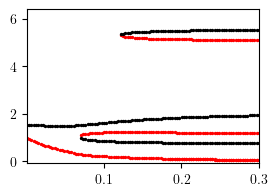

In [86]:
quick_plot_combined(a11_p0025,
                    #kw_f={'data_list':data_p0025_list},
                    #kw_r3d={'data_list':data_r3d_p0025_list},
                    kw_r={'etup':etup11})

# del=0.003

In [87]:
# del11_p003 = .003
# a11_p003 = nm.nmCoupling(**kw_nm, del1=del11_p003)

pfactor 20
* Loading p symbolic...
* Loading p symbolic...


KeyboardInterrupt: 

* Computing H thal0_35, order=2...


* Computing H thal1_35, order=2...


* Computing H thal0_35, order=3...


* Computing H thal1_35, order=3...


## Get Branches Full

In [ ]:
# kw_p003 = {'a':a11_p003,'del1':del11_p003,'recompute':False,
#             'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [ ]:
# data_p003_list = []

In [ ]:
# # mid 1
# dat = follow_phase_diffs(init=3,eps_init=0.01,eps_final=0.0005,deps=-.0005,**kw_p003)
# data_p003_list.append(dat)

In [ ]:
# # mid 2
# dat = follow_phase_diffs(init=3,eps_init=0.02,eps_final=0.0589,deps=.0005,**kw_p003)
# data_p003_list.append(dat)

In [ ]:
# # top 1f
# dat = follow_phase_diffs(init=.1,eps_init=0.2,eps_final=0.3,deps=.01,**kw_p003)
# data_p003_list.append(dat)

In [ ]:
# # top 1b
# dat = follow_phase_diffs(init=.1,eps_init=0.2,eps_final=0.18,deps=-.005,**kw_p003)
# data_p003_list.append(dat)

In [ ]:
# # bot 1f
# dat = follow_phase_diffs(init=1,eps_init=0.2,eps_final=0.3,deps=.01,**kw_p003)
# data_p003_list.append(dat)

In [ ]:
# # bot 1b
# dat = follow_phase_diffs(init=.5,eps_init=0.2,eps_final=0.18,deps=-.005,**kw_p003)
# data_p003_list.append(dat)

## Plot

In [ ]:
# quick_plot_combined(a11_p003,
#                     #kw_f={'data_list':data_p003_list},
#                     #kw_r3d={'data_list':data_r3d_p003_list},
#                     kw_r={'etup':etup11})

# del=0.005

In [ ]:
# del11_p005 = .005
# a11_p005 = nm.nmCoupling(system1,system2,
#                     #recompute_list=['p_data_gw0','p_data_gw1','h_data_gw0','h_data_gw1'],
#                     #recompute_list=['h_data_gw0','h_data_gw1'],
#                     #recompute_list=recompute_list,
#                     _n=('om0',1),_m=('om1',1),
#                     NH=1500,
#                     save_fig=False,
#                     del1=del11_p005)

## Get Branches Full

In [ ]:
# kw_p005 = {'a':a11_p005,'del1':del11_p005,
#             'bifdir':'bif1d_thal2/','_full_rhs':_full}

In [ ]:
# data_p005_list = []

In [ ]:
# # mid 1
# dat = follow_phase_diffs(init=3,eps_init=0.02,eps_final=0.0005,deps=-.0005,**kw_p005)
# data_p005_list.append(dat)

In [ ]:
# # mid 2
# dat = follow_phase_diffs(init=3,eps_init=0.02,eps_final=0.1,deps=.0005,**kw_p005)
# data_p005_list.append(dat)

In [ ]:
# # bot 1
# dat = follow_phase_diffs(init=.1,eps_init=0.005,eps_final=0.0005,deps=-.0005,**kw_p005)
# data_p005_list.append(dat)

In [ ]:
# # bot 2
# dat = follow_phase_diffs(init=.1,eps_init=0.005,eps_final=0.1,deps=.0005,**kw_p005)
# data_p005_list.append(dat)

## Plot

In [ ]:
# quick_plot_combined(a11_p005,
#                     #kw_f={'data_list':data_p005_list},
#                     #kw_r3d={'data_list':data_r3d_p005_list},
#                     kw_r={'etup':etup11})